In [9]:
import os
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMAGE_SIZE = (256, 256)
EPOCHS = 200
BATCH_SIZE = 16
MODEL_NAME = "LungConVT_Net"
DATA_CSV = "data_mapping.csv"

In [3]:
print("Loading dataset...")
crd_df = pd.read_csv(DATA_CSV)

Loading dataset...


In [4]:
# One-hot encode folder names
unique_classes = crd_df['Folder Name'].unique().tolist()
for cat in unique_classes:
    crd_df[cat] = crd_df['Folder Name'].apply(lambda x: 1 if x == cat else 0)

In [5]:
# Split data
train_df, test_df = train_test_split(crd_df, test_size=0.2, random_state=1993)
print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")

Training samples: 7367, Testing samples: 1842


In [6]:
# ---------------------------#
# Data Generators
# ---------------------------#
def get_train_generator(df, x_col, y_cols):
    datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        rescale=1.0/255.0
    )
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=BATCH_SIZE,
        target_size=IMAGE_SIZE,
        shuffle=True
    )

def get_test_generator(df, x_col, y_cols):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=BATCH_SIZE,
        target_size=IMAGE_SIZE,
        shuffle=False
    )

In [7]:
train_data = get_train_generator(train_df, "Complete Path", unique_classes)
test_data = get_test_generator(test_df, "Complete Path", unique_classes)

Found 7331 validated image filenames.
Found 1834 validated image filenames.


/home/updaterpc/miniconda3/envs/asifEnv/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 36 invalid image filename(s) in x_col="Complete Path". These filename(s) will be ignored.
  warnings.warn(
/home/updaterpc/miniconda3/envs/asifEnv/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 8 invalid image filename(s) in x_col="Complete Path". These filename(s) will be ignored.
  warnings.warn(


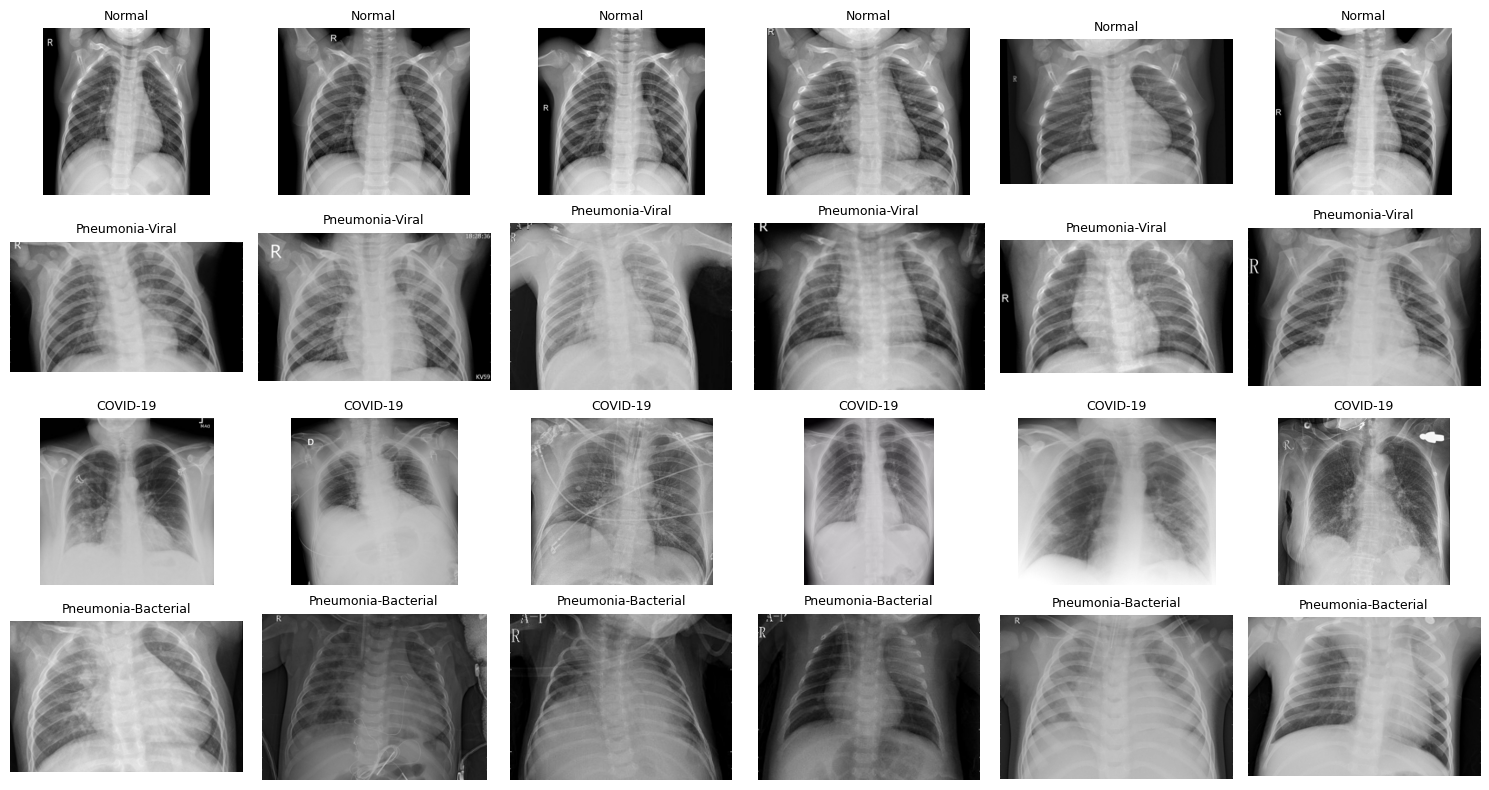

In [14]:
# ---------------------------#
# 🖼️ Visualize sample images for each class
# ---------------------------#
def visualize_samples(df, label_col='Folder Name', path_col='Complete Path', n_samples=4):
    """Display sample images from each class."""
    unique_classes = df[label_col].unique().tolist()
    plt.figure(figsize=(15, 8))
    for i, label in enumerate(unique_classes):
        subset = df[df[label_col] == label]
        samples = subset.sample(min(n_samples, len(subset)))
        for j, (_, row) in enumerate(samples.iterrows()):
            img = Image.open(row[path_col])
            plt.subplot(len(unique_classes), n_samples, i * n_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{label}", fontsize=9)
    plt.tight_layout()
    plt.show()

# Display 3 sample images per class
visualize_samples(train_df, n_samples=6)